In [1]:
!mkdir my_repo
!git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo

Cloning into 'my_repo'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 175 (delta 77), reused 145 (delta 47), pack-reused 0
Receiving objects: 100% (175/175), 4.32 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
%cd my_repo

/content/my_repo


In [3]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 1.6 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from utils import util_data

kaggle.json not found, you cannot use kaggle module.


In [5]:
df = pd.read_csv("data/processed/gsm.csv")
df.head(3)

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.3,1,0,1,0,1,1,4G,...,1,1,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.7,1,0,1,0,1,1,4G,...,1,1,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.0,1,0,1,1,1,1,4G,...,0,0,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0


In [6]:
# Show duplicated rows
df[df.duplicated(keep=False)]

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera


In [7]:
# Keep only the smartphones that are sold starting from 2015
df = df[df['launch_announced'] >= 2015].drop('launch_announced', axis=1)

df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
print(f"Null values:{df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

print(f"Number of rows: {df.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1657


We only need to create the one-hot encoding for the "network_technology" feature because the others have already been binarized from the preprocessing pipeline.

In [8]:
ohe_feat = ["network_technology"]

ohe_encoder = {}
for col in ohe_feat:
    ohe_encoder[col] = OneHotEncoder(sparse_output=False)
    # Get ohe data and column names
    ohe_data = ohe_encoder[col].fit_transform(df[col].values.reshape(-1, 1))
    new_names = ohe_encoder[col].get_feature_names_out([col])
    # Concat to the original df
    ohe_df = pd.DataFrame(ohe_data, columns=new_names)

    df = pd.concat([df, ohe_df], axis=1).drop(col, axis=1)

Then we also need to standardize continuous features to have the values in the same range.

In [9]:
num_cols = ["display_size", "battery", "display_width", "display_height", "memory_rom_gb",
            "memory_ram_gb", "main_camera_resolution", "selfie_camera_resolution"]

scaler_num = {}
for col in num_cols:
    scaler_num[col] = StandardScaler()
    df[col] = scaler_num[col].fit_transform(df[col].values.reshape(-1, 1))

In [ ]:
df.head()

,misc_price,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,...,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,network_technology_3G,network_technology_4G,network_technology_5G
0,599.00,1.012084,1,0,1,0,1,1,0.372172,1,...,2.404489,0.15989,1.164668,-0.403061,2.0,-0.281623,2.0,0.0,1.0,0.0
1,524.52,-0.023787,1,0,1,0,1,1,-0.731741,1,...,0.892572,0.15989,1.164668,-0.403061,2.0,-0.281623,2.0,0.0,1.0,0.0
2,329.00,0.494148,1,0,1,1,1,1,0.372172,0,...,0.653849,0.15989,0.186784,-0.403061,1.0,-0.281623,1.0,0.0,1.0,0.0
3,304.00,-0.196432,1,0,1,1,1,1,-0.486427,0,...,0.773211,0.15989,0.186784,-0.403061,1.0,-0.281623,1.0,0.0,1.0,0.0
4,110.00,-0.006522,0,1,0,1,0,0,-0.461896,0,...,-0.619344,0.15989,-0.302159,-0.347239,1.0,-0.685427,1.0,0.0,1.0,0.0


If we check the price distribution we can see that there is an outlier and we remove it from the data, because its value is very different from the other prices.

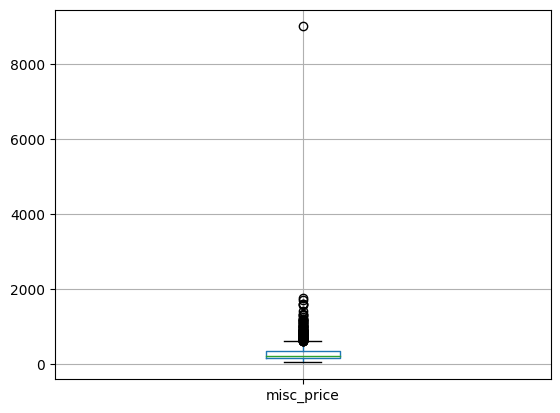

In [ ]:
df.boxplot(column=["misc_price"])
plt.show()

In [10]:
df = df[df['misc_price'] < 8000].reset_index(drop=True)

Given that we want to consider a classification problem we need to create bins for the different ranges of price, to split the data in a clever way we decided to consider the quantile and to compute the bounds with statistics.

In [11]:
q1 = df.misc_price.quantile(0.25)
q3 = df.misc_price.quantile(0.75)
# Take inter-quartile range
iqr = q3 - q1
# lower whiskers as 1.5 smaller than iqr
lower_bound = max(df.misc_price.min(), q1 - iqr * 1.5)
# upper whiskers as 1.5 greater than iqr
upper_bound = min(df.misc_price.max(), q3 + iqr * 1.5)

print(f"lower_bound: {lower_bound}, upper_bound: {upper_bound}")

lower_bound: 40.0, upper_bound: 600.0


In [12]:
df_iqr = df[df.misc_price.between(lower_bound, upper_bound, inclusive="both")]

print(f"Shape before: {df.shape}, shape after: {df_iqr.shape}")

Shape before: (1656, 22), shape after: (1551, 22)


We set four different labels that are representative of the price range of the different devices and we compute the bounds between the different price ranges.

In [13]:
target_labels = ["low", "low-medium", "medium", "high"]
_, bins = pd.cut(df_iqr.misc_price, bins=len(target_labels), retbins=True, labels=target_labels)
# _, bins = pd.qcut(df_iqr.misc_price, q=len(labels), retbins=True, labels=labels)

print(f"Bins: {bins}")

Bins: [ 39.44 180.   320.   460.   600.  ]


In [14]:
bins[0] = df.misc_price.min()
bins[-1] = df.misc_price.max()
lab_cat = pd.Series(index=df.index, dtype="object")

for lab, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Range {target_labels[lab]}: {l:.2f} - {u:.2f}")

    idx = df.misc_price.between(l, u, inclusive="both")
    lab_cat.loc[idx] = lab

Range low: 40.00 - 180.00
Range low-medium: 180.00 - 320.00
Range medium: 320.00 - 460.00
Range high: 460.00 - 1750.00


In [15]:
# Replace misc_price column with lab_cat
df["misc_price"] = lab_cat
df["misc_price"]

0       3
1       3
2       2
3       1
4       0
       ..
1651    0
1652    1
1653    0
1654    1
1655    1
Name: misc_price, Length: 1656, dtype: object

In [16]:
util_data.count_frequency_labels(df.misc_price)

,Frequency,Count
1,39.43%,653
0,34.06%,564
2,14.55%,241
3,11.96%,198


As you can see from the previous table the dataset is imbalanced and we need to weigh the samples differently during training.

After the quantization of the price we also have to remove all the samples that are now duplicated.

In [ ]:
df[df.duplicated(keep="first")].sort_values(by=df.columns.to_list())

,misc_price,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,...,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,network_technology_3G,network_technology_4G,network_technology_5G
1047,0,-1.750238,0,1,0,1,0,0,-1.712997,0,...,-1.733388,-0.859454,-1.280043,-0.696125,1.0,-1.089231,1.0,1.0,0.0,0.0
1563,0,-1.750238,0,1,0,1,0,0,-1.467683,0,...,-1.096791,-0.713833,-0.791101,-0.696125,1.0,-1.089231,1.0,0.0,1.0,0.0
620,0,-1.232302,0,1,0,1,0,0,-1.712997,0,...,-1.096791,-0.859454,-1.280043,-0.696125,1.0,-1.089231,1.0,0.0,1.0,0.0
1200,0,-1.232302,0,1,0,1,0,0,-1.712997,0,...,-1.096791,-0.859454,-1.280043,-0.696125,1.0,-1.089231,1.0,0.0,1.0,0.0
1221,0,-1.232302,0,1,0,1,0,0,-1.712997,0,...,-1.096791,-0.859454,-1.280043,-0.696125,1.0,-0.685427,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,3,0.494148,1,0,1,1,1,1,0.740143,0,...,0.653849,1.324855,2.142552,-0.417016,2.0,-0.281623,1.0,0.0,1.0,0.0
662,3,0.494148,1,1,1,1,1,1,0.126858,0,...,1.449594,0.159890,-0.302159,0.420310,1.0,-0.281623,1.0,0.0,1.0,0.0
776,3,1.167464,1,0,1,0,1,1,0.985457,1,...,2.563638,3.654785,2.142552,1.536744,3.0,1.871998,1.0,0.0,1.0,0.0
149,3,1.443696,1,0,1,0,1,1,1.108114,0,...,1.131296,1.324855,2.142552,2.094961,3.0,0.795188,1.0,0.0,0.0,1.0


In [17]:
# Remove duplicates and cast types to "float"
df = df.drop_duplicates().reset_index(drop=True)
df = df.astype({col: "float" for col in df.columns.tolist()})

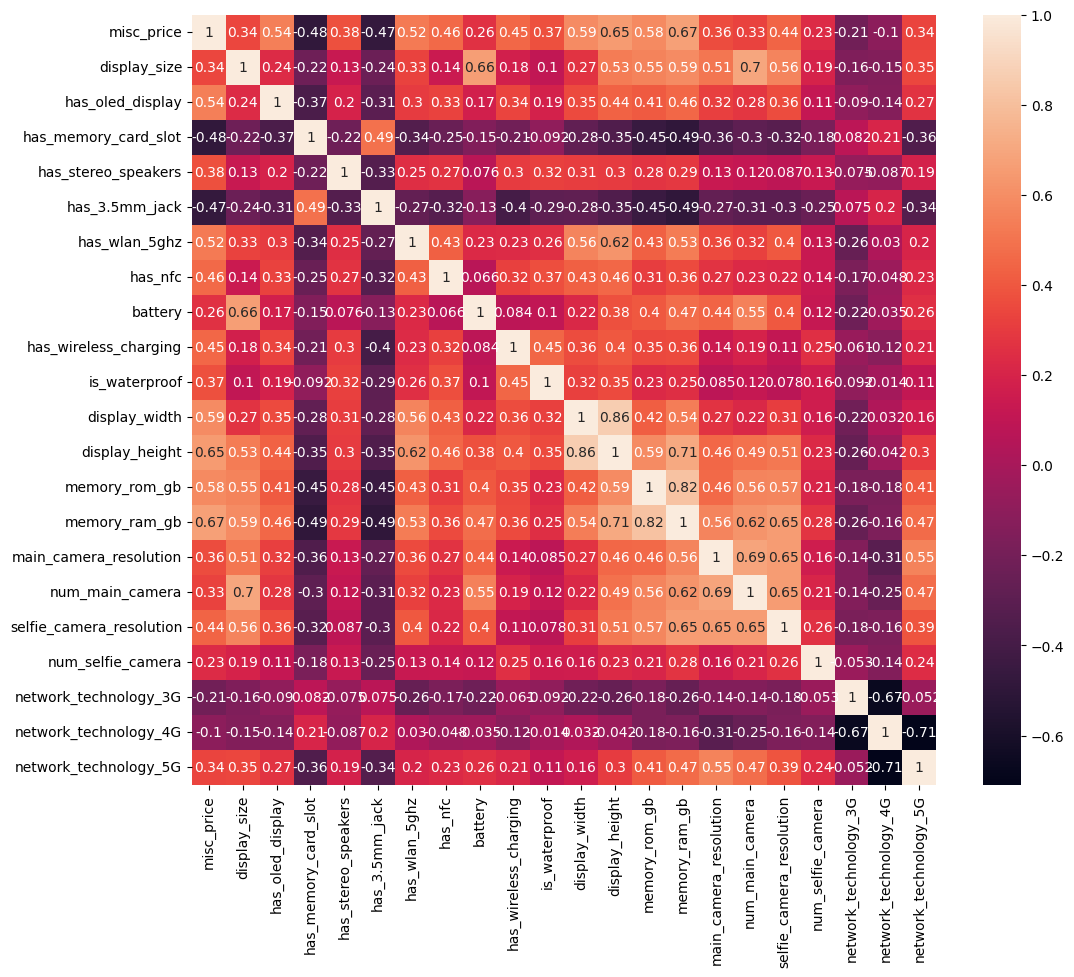

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [18]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["misc_price"]), df.misc_price, test_size=0.15, random_state=42)

In [ ]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1320, 21), X_test: (234, 21), y_train: (1320,), y_test: (234,)


In [19]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (1056, 21), X_val: (264, 21), y_train: (1056,), y_val: (264,)


## Models

We want to test different models on our dataset, starting from the simplest ones and then trying with more complex models such as LightGBM. 

The dataset is small, therefore we believe that simpler models can perform quite well on the test set without incurring in overfitting.

### Decision Trees (TODO)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Random Forest (TODO)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### LightGBM model

One of the main drawbacks of this model is that it can overfit with small datasets.

In [ ]:
import lightgbm as lgb
import warnings

from utils.util_models import LightGBM 

With the following parameters we can limit overfitting but the model accuracy on the training set will drop.

TODO: try to set the weights for the different features.

In [186]:
#@title #### Class for the model
class LightGBM:
    '''
        This class allows to build a lightgbm model using the sklearn api or the
        native lightgbm api.
    '''
    def __init__(self, api: str, parameters: dict, train_data: lgb.Dataset, 
                 val_data: lgb.Dataset=None):
        self.api = api
        self.parameters = parameters
        self.fitted = False

        if api == "sklearn":
            self.model = lgb.LGBMClassifier(**parameters)
            self.X_train, self.y_train = train_data.data, train_data.label
            self.X_val, self.y_val = val_data.data, val_data.label
        else:
            self.model = lgb.Booster(parameters, train_data)  
            self.train_data = train_data
            self.val_data = val_data


    def train_model(self, verbose: int=-100):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            if self.api == "sklearn":
                self.model.fit(self.X_train, self.y_train,
                               eval_set=[(X_train, y_train), (X_val, y_val)], verbose=verbose)
                training_evaluation = self.model.evals_result_
            else: 
                training_evaluation = {}
                
                self.model = lgb.train({**self.parameters, "verbose": verbose}, self.train_data,
                                       valid_sets=[self.train_data, self.val_data],
                                       verbose_eval=False, evals_result=training_evaluation)
                
            self.fitted = True
            self.train_eval = training_evaluation
    

    def predict(self, data):
        assert self.fitted, "You need to train the model beforehand."
        if self.api == "sklearn":
            predictions = self.model.predict(data)
        else:
            # Take the maximum probability position
            predictions = np.argmax(self.model.predict(data), axis=1)

        return predictions


    def compute_score(self, score_fn: Callable, data, y_true: list):
        y_pred = self.predict(data)
        score = score_fn(y_true, y_pred)

        return score

    
    def plot_metrics(self, metric: str="all", **kwargs):
        assert self.fitted, "You need to train the model with an evaluation set beforehand."

        metrics = self.parameters['metric']
        if metric == "all":
            for met in metrics:
                lgb.plot_metric(self.train_eval, metric=met,
                                title=f"{met} during training", **kwargs);

    
    def plot_info(self, kind, **kwargs):
        assert self.fitted, "You need to train the model beforehand."
        if kind == "importance":
            lgb.plot_importance(self.model, **kwargs)
        elif kind == "tree":
            lgb.plot_tree(self.model, **kwargs)
        else:
            print("ERROR: the selected kind of chart is not available.")

In [158]:
lgb_params = {"learning_rate": 0.05, "num_iterations":1000, "early_stopping_round":50, 
              "max_bin": 30, "num_leaves": 30, "lambda_l1": 0.3, "random_state":42,
              "force_row_wise":True, "objective":"multiclass", "metric":['multi_error', 'multi_logloss'],
              "num_class": 4}

# Create the data object to give as input to the model
train_data = lgb.Dataset(X_train, label=y_train, params={'verbose': -1}, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, params={'verbose': -1}, free_raw_data=False)

First of all let's create the model that uses the scikit learn api in order to test it on the dataset and to plot some information. 

#### Model with scikit-learn api 

In [194]:
lgb_model_sk = LightGBM(api="sklearn", parameters=lgb_params, train_data=train_data,
                         val_data=val_data)

In [195]:
# Train the model without verbose output
lgb_model_sk.train_model()

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3


We can plot the metrics considered during the training for the training and the validation dataset to check if there is some overfitting.

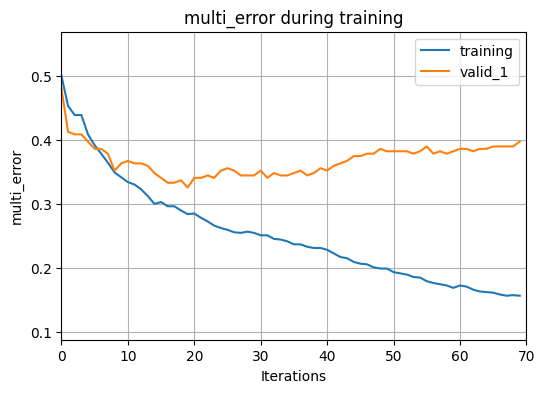

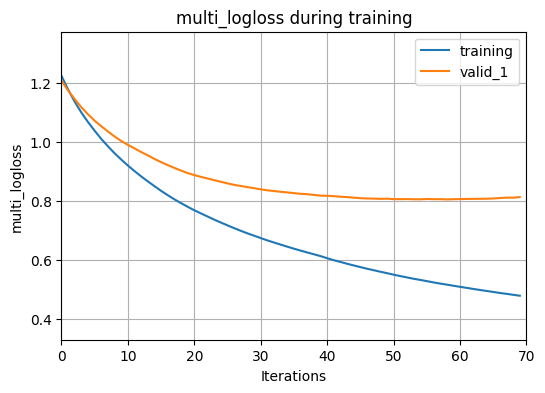

In [164]:
lgb_model_sk.plot_metrics(figsize=(6,4))

In [165]:
print(f"The model has an accuracy of {lgb_model_sk.compute_score(accuracy_score, X_train, y_train)*100:.2f}% on the training set.")
print(f"The model has an accuracy of {lgb_model_sk.compute_score(accuracy_score, X_test, y_test)*100:.2f}% on the test set.")

The model has an accuracy of 71.59% on the training set.
The model has an accuracy of 64.10% on the test set.


We can also plot the importance of the different features, computed by the model.

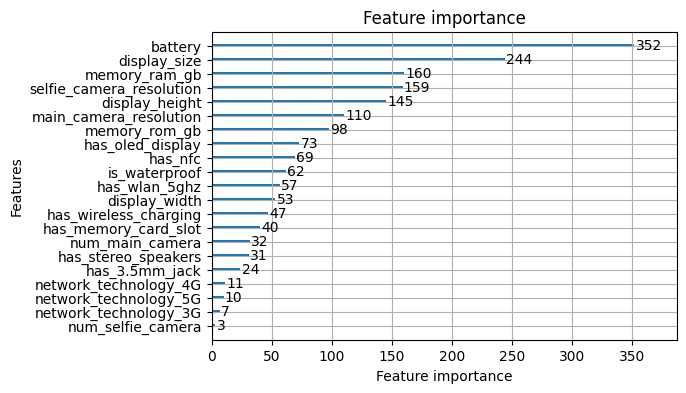

In [167]:
lgb_model_sk.plot_info(kind="importance", figsize=(6,4))

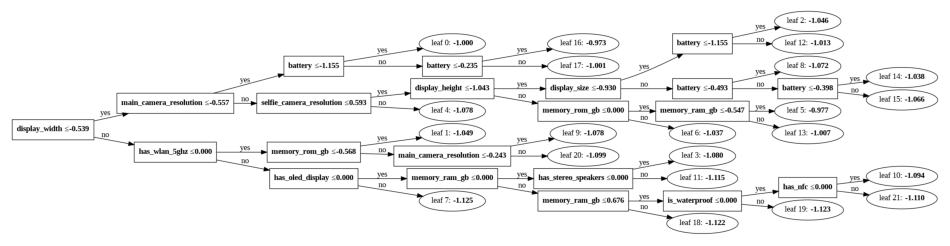

In [136]:
lgb_model_sk.plot_info(kind="tree", figsize=(12,8))

#### Model with lightgbm api

In [187]:
lgb_model_lgb = LightGBM("lgbm", lgb_params, train_data, val_data)

[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 1056, number of used features: 21


In [188]:
# Train the model without verbose output
lgb_model_lgb.train_model()

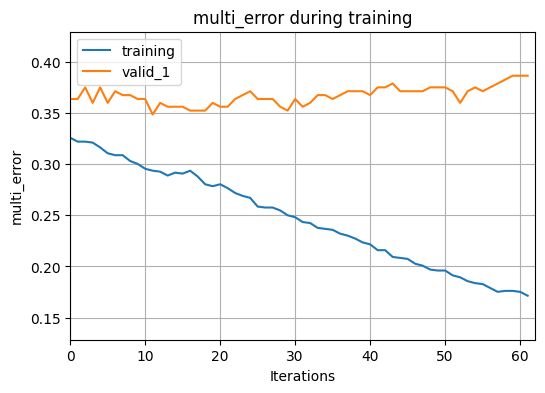

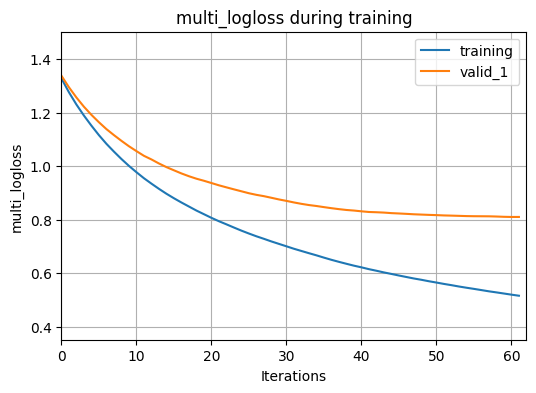

In [189]:
lgb_model_lgb.plot_metrics(figsize=(6,4))

In [190]:
print(f"The model has an accuracy of {lgb_model_lgb.compute_score(accuracy_score, X_train, y_train)*100:.2f}% on the training set.")
print(f"The model has an accuracy of {lgb_model_lgb.compute_score(accuracy_score, X_test, y_test)*100:.2f}% on the test set.")

The model has an accuracy of 70.64% on the training set.
The model has an accuracy of 63.25% on the test set.


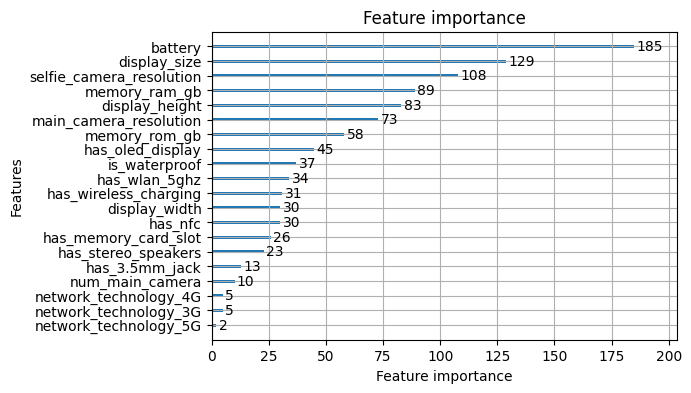

In [192]:
lgb_model_lgb.plot_info(kind="importance", figsize=(6,4))

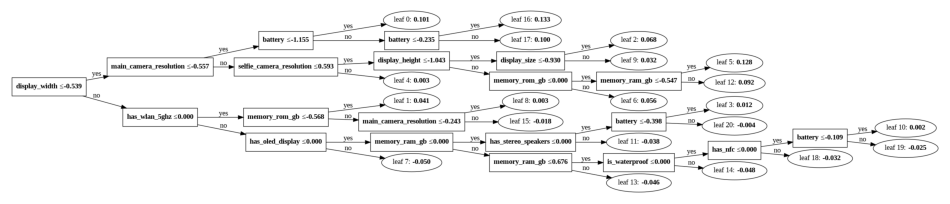

In [193]:
lgb_model_lgb.plot_info(kind="tree", figsize=(12,8))

## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT

In [ ]:
import tempfile

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
from omlt.block import OmltBlock

import onnx
from onnxmltools.convert.lightgbm.convert import convert
from onnxmltools.utils import save_model
import json
from skl2onnx.common.data_types import FloatTensorType

In [ ]:
x_test_np = X_test.values
y_test_np = y_test.values

In [ ]:
idx = 3
sample_idx = x_test_np[idx]
label_idx = y_test_np[idx]

#define dummy input tensor    
x_dummy = x_test_np[idx].reshape((1, -1))

# Define input region defined by infinity norm
epsilon_infty = 5e-1
lb = np.repeat(-1, len(sample_idx))
# lb = np.maximum(-1, sample_idx - epsilon_infty)
ub = np.repeat(1, len(sample_idx))
# ub = np.minimum(1, sample_idx + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(x_test_np.shape[1]):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

At this point we need to save the lightgbm classifier in a onnx model to work with omlt. 

In [ ]:
def get_onnx_model(model, save=True):
    # export onnx model
    float_tensor_type = FloatTensorType([None, model.num_feature()])
    initial_types = [('float_input', float_tensor_type)]

    onnx_model = convert(model, initial_types=initial_types,
                         target_opset=8)
    if save:
        save_model(onnx_model, './xgboost_model.onnx')     
    return onnx_model

onnx_model = get_onnx_model(lgb_model, save=False)

We define the opt_model as a ConcreteModel() imported from Pyomo. By first initializing an OmltBlock(), we can add a formulation using the build_formulation function. For tree ensembles we use the GradientBoostedTreeModel object and a BigMFormulation imported from omlt.gbt. Here we provide the onnx_model and input bounds of the black-box function. The add_tree_model function captures all procedures and adds a tree model block to an existing Pyomo model. You can build the Pyomo model and print the formulation using pprint() to check if everything works correctly.

In [ ]:
def add_tree_model(opt_model, onnx_model, input_bounds):
    # init omlt block and gbt model based on the onnx format
    opt_model.gbt = OmltBlock()
    gbt_model = GradientBoostedTreeModel(onnx_model, 
                                         scaled_input_bounds=input_bounds)
    
    # omlt uses a big-m formulation to encode the tree models
    formulation = GBTBigMFormulation(gbt_model)
    opt_model.gbt.build_formulation(formulation)

opt_model = pyo.ConcreteModel()
add_tree_model(opt_model, onnx_model, input_bounds)

TODO: continue changing old stuffs and adapting to the new model and data.

#### Old stuffs

In [ ]:
#@title ### Download cplex from drive and install it
id_cplex_file = "1ePJy9nsNYfkvErFuedT6mbPmTfriQ2e8"
gdown.download(id=id_cplex_file, output="cplex_binary.bin", quiet=False)

# We can use /usr/bin/cplex as installation path when requested
!bash cplex_binary.bin

Define the objective expression to optimize.

ATTENTION: if you run twice the cell an error will be raised because we overwrite the block, hence you need to run again the cell in which we create the model before to apply changes.

In [ ]:
medians = np.median(X_train, axis=0)
distances_j = lambda j: [np.abs(X_train[i,j]-medians[j]) for i in range(len(X_train))]

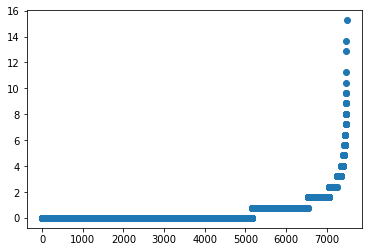

In [ ]:
plt.scatter(np.arange(len(distances_j(5))), np.sort(distances_j(5)))

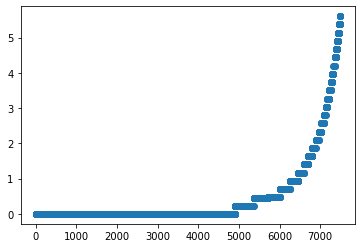

In [ ]:
plt.scatter(np.arange(len(distances_j(13))), np.sort(distances_j(13)))

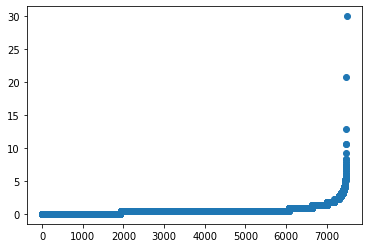

In [ ]:
plt.scatter(np.arange(len(distances_j(14))), np.sort(distances_j(14)))

In [ ]:
# Create an expression that is the difference between the numpy array and the indexed variable
medians = np.median(X_train, axis=0)
MAD = lambda j: np.median([(X_train[i,j]-medians[j])**2 for i in range(len(X_train))])+0.0001

diff_expr = sum(((sample_idx[i] - m.nn.inputs[i])**2)/MAD(i) for i in range(len(sample_idx)))

# Set the objective function to be the difference expression
# m.obj = pyo.Objective(expr=((m.nn.outputs[0] - 1e-3)**2))
m.obj = pyo.Objective(expr=((m.nn.outputs[0] - 1)**2 + diff_expr))

Check what is the expression

In [ ]:
m.obj.expr.to_string()

'(-2.1237396965035487 - nn.inputs[0])**2/0.6516353444604 + (2.0720732888939324 - nn.inputs[1])**2/0.34623306121992614 + (-0.04351394719762343 - nn.inputs[2])**2/0.10124551965735235 + (1.7089763559995648 - nn.inputs[3])**2/0.3471737320369636 + (1.8339104173603789 - nn.inputs[4])**2/0.3803238127439624 + (3.549286259709461 - nn.inputs[5])**2/0.0001 + (-1.5579603212136566 - nn.inputs[6])**2/0.06504566196263667 + (-0.5031576652363163 - nn.inputs[7])**2/0.0030953442295281477 + (-1.0488330153245893 - nn.inputs[8])**2/0.36107624481471046 + (-1.2815928873154365 - nn.inputs[9])**2/1.1664687776793121 + (2.075747003769893 - nn.inputs[10])**2/0.37118085351501906 + (-0.47375867541069705 - nn.inputs[11])**2/0.2980712520692345 + (0.4193474489240483 - nn.inputs[12])**2/0.45131853211456807 + (0.0029525990677453434 - nn.inputs[13])**2/0.0001 + (0.7170676851210651 - nn.inputs[14])**2/0.21347155762320297 + (-0.4840680843240054 - nn.inputs[15])**2/0.6532802264991835 + (nn.outputs[0] - 1)**2'

Install a solver to optimize the problem.

In [ ]:
!apt-get install -y -qq coinor-cbc

^C


In [ ]:
#pyo_solution = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(m, tee=True)
pyo_solution = pyo.SolverFactory('cplex', executable='/usr/bin/cplex/cplex/bin/x86-64_linux/cplex').solve(m, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmp7r862w9a.cplex.log' open.
CPLEX> Problem '/tmp/tmp0r3e1jli.pyomo.lp' read.
Read time = 0.01 sec. (0.13 ticks)
CPLEX> Problem name         : /tmp/tmp0r3e1jli.pyomo.lp
Objective sense      : Minimize
Variables            :     437  [Nneg: 1,  Box: 306,  Free: 2,  Binary: 128,
                                 Qobj: 17]
Objective nonzeros   :      18
Objective Q nonzeros :      17
Linear constraints   :     677  [Less: 384,  Greater: 128,  Equal: 165]
  Nonzeros           :    6408
  RHS nonzeros       :     258

Variables            : Min LB: -53.65274        Max UB: 31.27704       
Objec

In [ ]:
# will show you the evaluation of the OBJ function
m.obj.display()
# will print the evaluation of the OBJ function, and give direct access to the value
print(m.obj.expr())   

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 65009.41689532917
65009.41689532917


Extract the values of the found sample and test if it actually leads to the desired label.

In [ ]:
def evaluate_sample(data_loader):
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch.to(device)
            # inference
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())

    y_pred_list = [y[0] for ys in y_pred_list for y in ys]
    return y_pred_list

eval_test = evaluate_sample(test_loader)

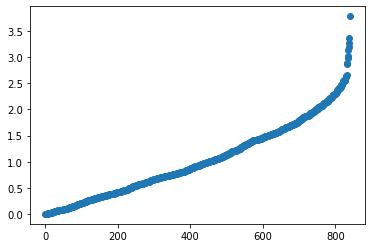

In [ ]:
positive_test = [x for x in eval_test if x > 0]

plt.scatter(np.arange(len(positive_test)), np.sort(positive_test))
print("Median: " + np.median(positive_test))

In [ ]:
count_sample_dict = list(m.nn.inputs.get_values().values())

test_fin = torch.tensor([count_sample_dict])

In [ ]:
model.eval()

with torch.no_grad():
    test_fin = test_fin.to(device)
    y_test_pred = model(test_fin)
    print(y_test_pred)
    y_test_pred = torch.sigmoid(y_test_pred)
    print(y_test_pred)
    y_pred_tag = torch.round(y_test_pred)

print("The sample has now {} as label".format(y_pred_tag))

tensor([[0.1062]])
tensor([[0.5265]])
The sample has now tensor([[1.]]) as label


### Dice

In [ ]:
!pip install -q dice-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.7 MB/s eta 0:00:00


In [ ]:
import dice_ml

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [ ]:
df_dice = pd.concat([X_train, y_train], axis=1)
df_dice.head()

,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,...,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,network_technology_3G,network_technology_4G,network_technology_5G,misc_price
1544,-0.369077,0.0,0.0,0.0,1.0,0.0,1.0,-0.486427,0.0,0.0,...,-0.422592,0.186784,-0.347239,2.0,-0.281623,1.0,0.0,1.0,0.0,1.0
876,0.839438,0.0,1.0,0.0,1.0,0.0,1.0,-0.118456,0.0,1.0,...,0.159890,0.186784,-0.347239,1.0,-0.281623,1.0,0.0,1.0,0.0,1.0
1339,0.873967,0.0,1.0,0.0,1.0,0.0,0.0,0.776940,0.0,0.0,...,0.159890,0.186784,-0.347239,2.0,1.333593,1.0,0.0,1.0,0.0,1.0
1424,-0.455400,0.0,1.0,0.0,1.0,0.0,0.0,-0.486427,0.0,0.0,...,0.159890,0.186784,-0.417016,2.0,-0.685427,1.0,0.0,1.0,0.0,0.0
287,-0.455400,0.0,1.0,0.0,1.0,0.0,0.0,-0.977055,0.0,0.0,...,-0.713833,-0.791101,-0.347239,1.0,-0.281623,1.0,0.0,1.0,0.0,0.0


In [ ]:
cont_features = ['display_size', 'battery', 'display_width', 'display_height', 'memory_rom_gb',
                 'memory_ram_gb', 'main_camera_resolution', 'selfie_camera_resolution']
# Dataset for training an ML model
dice_data = dice_ml.Data(dataframe=df_dice,
                         continuous_features=df_dice.columns[:-1].tolist(),
                         outcome_name='misc_price')

# Pre-trained ML model
m = dice_ml.Model(model=lgb_model, backend='sklearn')

# DiCE explanation instance
exp = dice_ml.Dice(dice_data, m, method="genetic")

In [ ]:
idx = 40
count_class = 2

orig_sample = X_train.iloc[[idx]]
orig_sample_lab = y_train.iloc[idx]

e1 = exp.generate_counterfactuals(orig_sample, total_CFs=1, desired_class=count_class)
e1.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
idx = 40
count_class = 2

orig_sample = X_train.iloc[[idx]]
orig_sample_lab = y_train.iloc[idx]

e1 = exp.generate_counterfactuals(orig_sample, total_CFs=1, desired_class=count_class)
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

Query instance (original outcome : 3)


,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,misc_price
0,0.535065,1.0,0.0,0.0,1.0,1.0,1.0,0.81794,0.0,0.0,0.417097,1.174779,1.423585,1.366104,3.386887,2.605155,3.091665,-0.220643,3.0



Diverse Counterfactual set (new outcome: 2)


,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,misc_price
0,0.535065,1.0,0.0,0.0,1.0,1.0,1.0,0.863561,0.0,0.0,0.417097,1.174779,1.423585,0.751185,2.239823,2.605154,0.907021,-0.220643,2


In [ ]:
count_sample = np.array([0.535065, 1, 0, 0, 1, 1, 1, 0.863561, 0, 0, 0.417097, 1.174779, 1.423585, 0.751185, 2.239823, 2.605154, 0.907021, -0.220643])

In [ ]:
def get_values_from_scaled(scaler_num, features, count_sample, orig_sample):
    new_values = []
    old_values = []
    for feat, c_val, o_val in zip(features, count_sample, orig_sample):
        if feat in scaler_num:
            new = scaler_num[feat].inverse_transform(np.reshape(c_val, (1, 1)))[0]
            old = scaler_num[feat].inverse_transform(np.reshape(o_val, (1, 1)))[0]
            new_values.append(new[0])
            old_values.append(old[0])
        else:
            new_values.append(c_val)
            old_values.append(o_val)
    return new_values, old_values

In [ ]:
new_val, old_val = get_values_from_scaled(scaler_num, X_train.columns, count_sample, orig_sample.to_numpy()[0])

In [ ]:
comp_df = pd.DataFrame(list(zip(old_val, new_val)), index=X_train.columns, columns=['Original_sample','Counterfactual'])
# Add labels
comp_df.loc['misc_price'] = [orig_sample_lab, count_class]
comp_df

,Original_sample,Counterfactual
display_size,6.44,6.440000
has_oled_display,1.00,1.000000
has_memory_card_slot,0.00,0.000000
has_stereo_speakers,0.00,0.000000
has_3.5mm_jack,1.00,1.000000
has_wlan_5ghz,1.00,1.000000
has_nfc,1.00,1.000000
battery,4350.00,4400.000406
has_wireless_charging,0.00,0.000000
is_waterproof,0.00,0.000000
